# Run the speciation model with fastscape

In [1]:
import numpy as np
import pandas as pd
import xsimlab as xs
import matplotlib.pyplot as plt

from fastscape.models import basic_model

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from paraspec.fastscape_ext import IR12Speciation, DD03Speciation, FastscapeElevationTrait
from paraspec.fastscape_ext import CompoundEnvironment, ElevationEnvField1, ElevationEnvField2
from paraspec.fastscape_ext import RandomSeedFederation

## Speciation without competition in an evolving landscape

In [2]:
model = basic_model.update_processes({
    'life': IR12Speciation,
    'trait_elev1':FastscapeElevationTrait,
    'trait_elev2':FastscapeElevationTrait,
    'life_env': CompoundEnvironment,
    'elevation1':ElevationEnvField1,
    'elevation2':ElevationEnvField2,
     'random': RandomSeedFederation
})

model

<xsimlab.Model (23 processes, 29 inputs)>
grid
    shape               [in] ('shape_yx',) nb. of grid nodes in (y, x)
    length              [in] ('shape_yx',) total grid length in (y, x)
boundary
    status              [in] () or ('border',) node status at borders
fs_context
uplift
    rate                [in] () or ('y', 'x') uplift rate
tectonics
init_topography
    seed                [in] random seed
surf2erode
init_erosion
diffusion
    diffusivity         [in] () or ('y', 'x') diffusivity (transpor...
flow
drainage
spl
    k_coef              [in] () or ('y', 'x') bedrock channel incis...
    area_exp            [in] drainage area exponent
    slope_exp           [in] slope exponent
erosion
vmotion
topography
terrain
trait_elev2
    init_trait_min      [in] min initial trait value
    init_trait_max      [in] max initial trait value
    lin_slope           [in] slope of opt. trait vs. elevation line...
    norm_min            [in] min elevation value for normalization
    norm

In [3]:
in_ds = xs.create_setup(
    model=model,
    clocks={
        'time': np.linspace(0., 10e6, 1001),
        'out': np.linspace(0., 10e6, 101)
    },
    master_clock='time',
    input_vars={
        'grid__shape': [101, 201], 
        'grid__length': [1e5, 2e5], 
        'boundary__status': ['looped', 'looped', 'fixed_value', 'fixed_value'],
        'uplift__rate': 1e-3,
        'spl__k_coef': 1e-4,
        'diffusion__diffusivity': 1e-3,
        'random':{
             'seed': 1234},
        'trait_elev1': {
            'init_trait_min':0.5,
            'init_trait_max':0.5,
            'lin_slope':0.95,
            'norm_min':0,
            'norm_max':400,
        },
        'trait_elev2': {
            'init_trait_min':0.5,
            'init_trait_max':0.5,
            'lin_slope':-0.95,
            'norm_min':0,
            'norm_max':400,
        },
        'life': {
            'init_abundance': 100,
            'nb_radius': 2e4,
            'car_cap': 25,
            'sigma_mov': 1000.,
            'mut_prob': 1.0,
            'sigma_mut': 0.05, 
            'sigma_env_trait': 0.5,
            'random_seed':1234
        }
    },
    output_vars={
        'topography__elevation': 'out',
        'drainage__area': 'out',
        'life__x': 'out',
        'life__y': 'out',
        'life__trait': 'out',
        'life__taxon_id': 'out',
        'life__ancestor_id': 'out'
    }
)

In [4]:
with xs.monitoring.ProgressBar():
    out_ds = in_ds.xsimlab.run(model=model)

             0% | initialize 

In [5]:
out_ds

<xarray.Dataset>
Dimensions:                      (border: 4, out: 101, y: 101, x: 201, shape_yx: 2, ind: 492, trait: 2, time: 1001)
Coordinates:
  * border                       (border) object 'left' 'right' 'top' 'bottom'
  * out                          (out) float64 0.0 1e+05 2e+05 ... 9.9e+06 1e+07
  * time                         (time) float64 0.0 1e+04 ... 9.99e+06 1e+07
  * x                            (x) float64 0.0 1e+03 2e+03 ... 1.99e+05 2e+05
  * y                            (y) float64 0.0 1e+03 2e+03 ... 9.9e+04 1e+05
Dimensions without coordinates: shape_yx, ind, trait
Data variables: (12/36)
    boundary__status             (border) <U11 'looped' ... 'fixed_value'
    diffusion__diffusivity       float64 0.001
    drainage__area               (out, y, x) float64 3e+06 1.4e+07 ... 2e+06
    grid__length                 (shape_yx) float64 1e+05 2e+05
    grid__shape                  (shape_yx) int64 101 201
    init_topography__seed        float64 nan
    ...                           ...
    trait_elev2__init_trait_max  float64 0.5
    trait_elev2__init_trait_min  float64 0.5
    trait_elev2__lin_slope       float64 -0.95
    trait_elev2__norm_max        int64 400
    trait_elev2__norm_min        int64 0
    uplift__rate                 float64 0.001

In [6]:
individuals_data = {}
#reshape trait data
for i in range(out_ds.life__trait.shape[2]):
    individuals_data['life__trait_'+str(i)] = out_ds.life__trait[:,:,i]
out_ds=out_ds.assign(individuals_data)

In [7]:
df = (
    out_ds
    # only keep paraspec output variables
    .drop_dims([d for d in out_ds.dims if d not in ('out', 'ind')])
    .drop_vars(in_ds, errors='ignore')
    # convert to a dataframe
    # see https://xarray-simlab.readthedocs.io/en/latest/io_storage.html#dynamically-sized-arrays
    .stack(fpop=('out', 'ind'))
    .dropna('fpop', how='all')
    .to_dataframe()
    # clean
    .rename(columns=lambda name: name.replace('life__', ''))
    .dropna()
    .reset_index()
)

df

,out,ind,ancestor_id,taxon_id,x,y,trait_0,trait_1
0,0.0,0,0.0,1.0,195339.953340,29784.009062,0.500000,0.500000
1,0.0,1,0.0,1.0,76039.147004,61916.101637,0.500000,0.500000
2,0.0,2,0.0,1.0,184649.246753,30175.742962,0.500000,0.500000
3,0.0,3,0.0,1.0,52338.484773,17484.645113,0.500000,0.500000
4,0.0,4,0.0,1.0,63819.411683,49550.519522,0.500000,0.500000
...,...,...,...,...,...,...,...,...
47124,10000000.0,479,12480.0,12630.0,2637.429241,28935.742387,0.360413,0.439082
47125,10000000.0,480,12480.0,12630.0,8346.004379,29336.124391,0.457996,0.353759
47126,10000000.0,481,12481.0,12631.0,14921.627882,51428.178926,0.296583,0.650751
47127,10000000.0,482,12481.0,12631.0,20062.943274,42562.268915,0.417042,0.709698


## Plot population

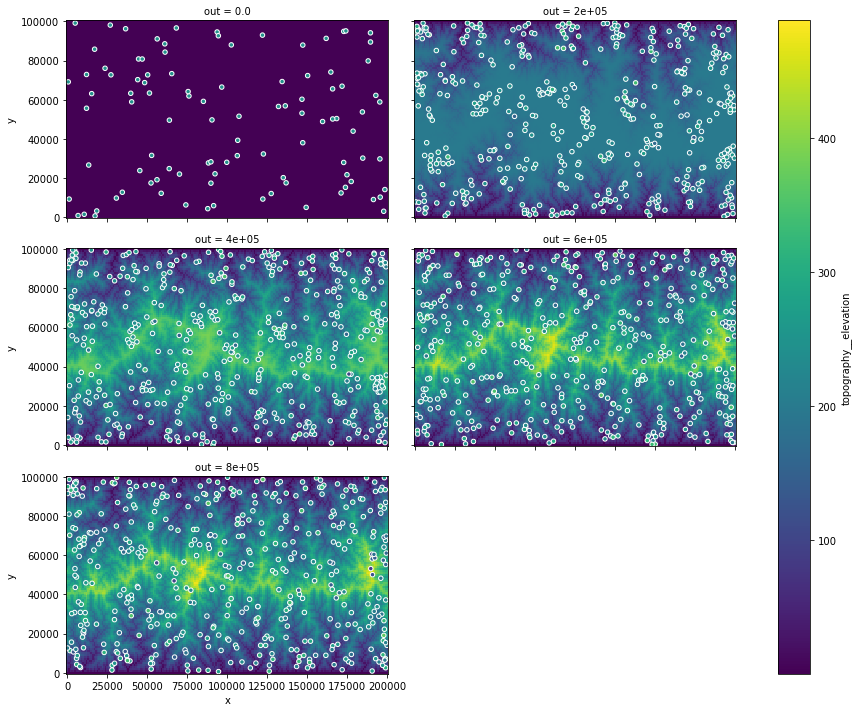

In [8]:
times = np.arange(0, 1e6, 2e5)
elev_max = out_ds.topography__elevation.max()


fg = (out_ds
      .sel(out=times)
      .topography__elevation.plot(col='out', col_wrap=2, figsize=(13, 10)))


for ax, t in zip(fg.axes.ravel(), times):
    pop = df[df.out==t]
    ax.scatter(pop.x, pop.y, c=pop.trait_0, vmin=0, vmax=1, s=20, edgecolor='w')

Text(0.5, 0, 'Time(years)')

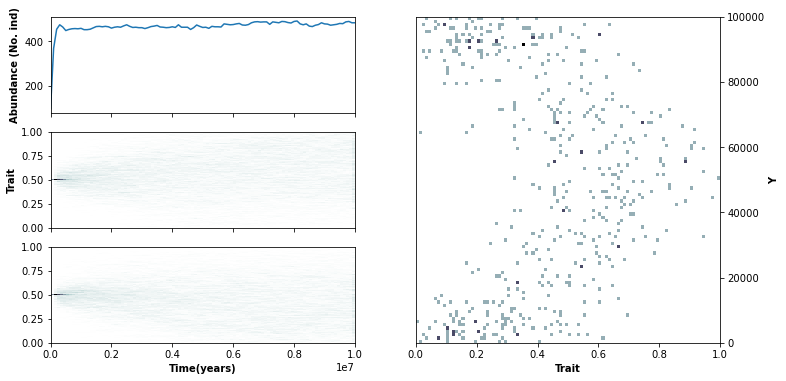

In [9]:
fig2, axs2 = plt.subplots(3, 2, sharex="col", figsize=(12, 6))
gs2 = axs2[1, 1].get_gridspec()
for ax in axs2[0:, -1]:
    ax.remove()
axbig = fig2.add_subplot(gs2[0:, -1])
axs2[0,0].plot(df.groupby('out').size())
h,xedge,yedge,_=axs2[1,0].hist2d(x=df['out'], y=df['trait_0'], 
                                 range=((0, 10e6), (0, 1)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=axs2[2,0].hist2d(x=df['out'], y=df['trait_1'], 
                                 range=((0, 10e6), (0, 1)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=axbig.hist2d(x=df['trait_1'].loc[df['out']==max(df['out'])], 
                             y=df['y'].loc[df['out']==max(df['out'])], 
                                 range=((0, 1), (0, 1e5)), 
                                 bins=(100, 100), cmap='bone_r')

axbig.yaxis.set_label_position("right")
axbig.yaxis.tick_right()
axbig.set_ylabel('Y', weight='bold')
axbig.set_xlabel('Trait', weight='bold')
axs2[0,0].set_ylabel('Abundance (No. ind)', weight='bold')
axs2[1,0].set_ylabel('Trait', weight='bold')
axs2[2,0].set_xlabel('Time(years)', weight='bold')

## Speciation with competition in an evolving landscape

In [10]:
model2 = basic_model.update_processes({
    'life': DD03Speciation,
    'trait_elev1':FastscapeElevationTrait,
    'trait_elev2':FastscapeElevationTrait,
    'life_env': CompoundEnvironment,
    'elevation1':ElevationEnvField1,
    'elevation2':ElevationEnvField2,
     'random': RandomSeedFederation
})
model2

<xsimlab.Model (23 processes, 32 inputs)>
grid
    shape                [in] ('shape_yx',) nb. of grid nodes in (y...
    length               [in] ('shape_yx',) total grid length in (y...
boundary
    status               [in] () or ('border',) node status at borders
fs_context
uplift
    rate                 [in] () or ('y', 'x') uplift rate
tectonics
init_topography
    seed                 [in] random seed
surf2erode
init_erosion
diffusion
    diffusivity          [in] () or ('y', 'x') diffusivity (transpo...
flow
drainage
spl
    k_coef               [in] () or ('y', 'x') bedrock channel inci...
    area_exp             [in] drainage area exponent
    slope_exp            [in] slope exponent
erosion
vmotion
topography
terrain
trait_elev2
    init_trait_min       [in] min initial trait value
    init_trait_max       [in] max initial trait value
    lin_slope            [in] slope of opt. trait vs. elevation lin...
    norm_min             [in] min elevation value for normalization


In [11]:
in_ds2 = xs.create_setup(
    model=model2,
    clocks={
        'time': np.linspace(0., 10e6, 1001),
        'out': np.linspace(0., 10e6, 101)
    },
    master_clock='time',
    input_vars={
        'grid__shape': [101, 201],
        'grid__length': [1e5, 2e5],
        'boundary__status': ['looped', 'looped', 'fixed_value', 'fixed_value'],
        'uplift__rate': 1e-3,
        'spl__k_coef': 1e-4,
        'diffusion__diffusivity': 1e-3,
        'random':{
             'seed': 1234},
        'trait_elev1': {
            'init_trait_min':0.5,
            'init_trait_max':0.5,
            'lin_slope':0.95,
            'norm_min':0,
            'norm_max':400,
        },
        'trait_elev2': {
            'init_trait_min':0.5,
            'init_trait_max':0.5,
            'lin_slope':-0.95,
            'norm_min':0,
            'norm_max':400,
        },
        'life': {
            'init_abundance': 100,
            'birth_rate': 1.0,
            'movement_rate': 5.,
            'car_cap_max': 500.,
            'mut_prob': 1.0,
            'sigma_mut': 0.05,
            'sigma_mov': 1000.,
            'sigma_env_trait': 0.5,
            'sigma_comp_trait': 0.5,
            'sigma_comp_dist': 0.5,
            'random_seed': 1234
        }
    },
    output_vars={
        'topography__elevation': 'out',
        'drainage__area': 'out',
        'life__x': 'out',
        'life__y': 'out',
        'life__trait': 'out',
        'life__taxon_id': 'out',
        'life__ancestor_id': 'out'
    }
)

In [12]:
with xs.monitoring.ProgressBar():
    out_ds2 = in_ds2.xsimlab.run(model=model2)

             0% | initialize 

In [13]:
individuals_data2 = {}
for i in range(out_ds2.life__trait.shape[2]):
    individuals_data2['life__trait_'+str(i)] = out_ds2.life__trait[:,:,i]
out_ds2=out_ds2.assign(individuals_data2)

In [14]:
df2 = (
    out_ds2
    # only keep paraspec output variables
    .drop_dims([d for d in out_ds2.dims if d not in ('out', 'ind')])
    .drop_vars(in_ds2, errors='ignore')
    # convert to a dataframe
    # see https://xarray-simlab.readthedocs.io/en/latest/io_storage.html#dynamically-sized-arrays
    .stack(fpop=('out', 'ind'))
    .dropna('fpop', how='all')
    .to_dataframe()
    # clean
    .rename(columns=lambda name: name.replace('life__', ''))
    .dropna()
    .reset_index()
)


df2

,out,ind,ancestor_id,taxon_id,x,y,trait_0,trait_1
0,0.0,0,0.0,1.0,195339.953340,29784.009062,0.500000,0.500000
1,0.0,1,0.0,1.0,76039.147004,61916.101637,0.500000,0.500000
2,0.0,2,0.0,1.0,184649.246753,30175.742962,0.500000,0.500000
3,0.0,3,0.0,1.0,52338.484773,17484.645113,0.500000,0.500000
4,0.0,4,0.0,1.0,63819.411683,49550.519522,0.500000,0.500000
...,...,...,...,...,...,...,...,...
49396,10000000.0,463,21500.0,21736.0,1101.945568,71394.903477,0.205253,0.427869
49397,10000000.0,464,21483.0,21729.0,142721.920070,6372.952271,0.362943,0.449230
49398,10000000.0,465,21422.0,21683.0,46177.942907,1141.724126,0.836084,0.339356
49399,10000000.0,466,21422.0,21683.0,29977.378118,3654.163143,0.827574,0.204462


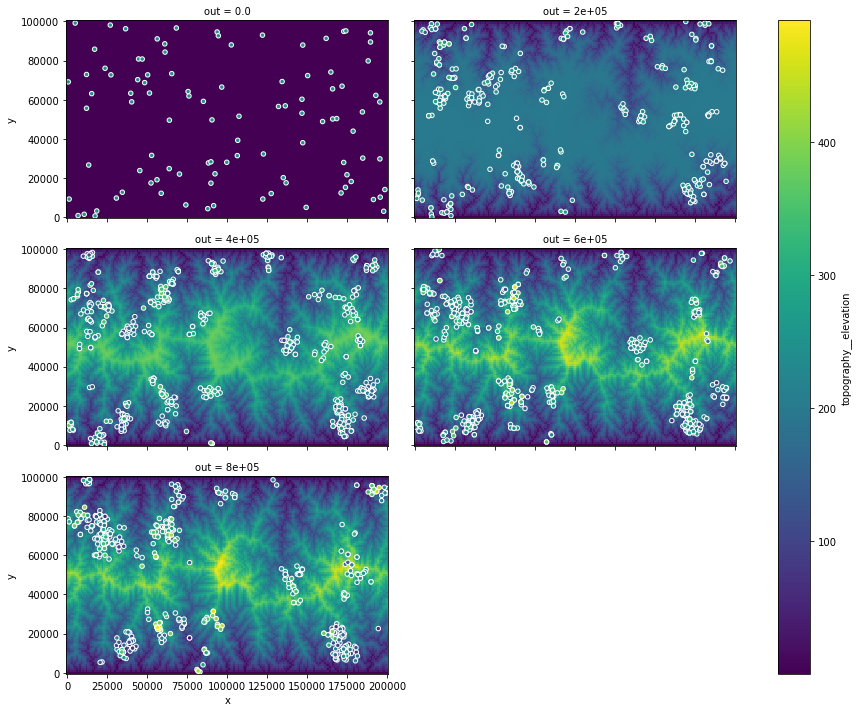

In [18]:
times = np.arange(0, 1e6, 2e5)
elev_max = out_ds2.topography__elevation.max()


fg = (out_ds2
      .sel(out=times)
      .topography__elevation.plot(col='out', col_wrap=2, figsize=(13, 10)))


for ax, t in zip(fg.axes.ravel(), times):
    pop = df2[df2.out==t]
    ax.scatter(pop.x, pop.y, c=pop.trait_1, vmin=0, vmax=1, s=20, edgecolor='w')

Text(0.5, 0, 'Time(years)')

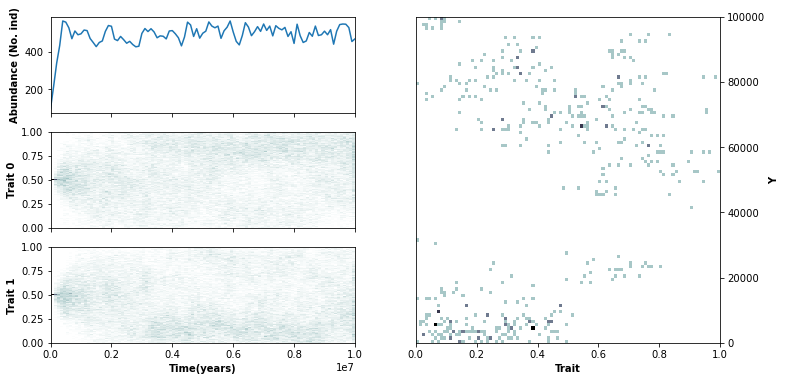

In [17]:
fig5, axs5 = plt.subplots(3, 2, sharex="col", figsize=(12, 6))
gs5 = axs5[1, 1].get_gridspec()
for ax in axs5[0:, -1]:
    ax.remove()
axbig = fig5.add_subplot(gs5[0:, -1])
axs5[0,0].plot(df2.groupby('out').size())
h,xedge,yedge,_=axs5[1,0].hist2d(x=df2['out'], y=df2['trait_0'], 
                                 range=((0, 10e6), (0, 1)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=axbig.hist2d(x=df2['trait_1'].loc[df2['out']==max(df2['out'])], 
                             y=df2['y'].loc[df2['out']==max(df2['out'])], 
                                 range=((0, 1), (0, 1e5)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=axs5[2,0].hist2d(x=df2['out'], y=df2['trait_1'], 
                                 range=((0, 10e6), (0, 1)), 
                                 bins=(100, 100), cmap='bone_r')
axbig.yaxis.set_label_position("right")
axbig.yaxis.tick_right()
axbig.set_ylabel('Y', weight='bold')
axbig.set_xlabel('Trait', weight='bold')
axs5[0,0].set_ylabel('Abundance (No. ind)', weight='bold')
axs5[1,0].set_ylabel('Trait 0', weight='bold')
axs5[2,0].set_ylabel('Trait 1', weight='bold')
axs5[2,0].set_xlabel('Time(years)', weight='bold')